# 第2章 深度学习基础

## 2.1 线性回归

### 2.1.2 线性回归的表示方法

定义两个1000维的向量

In [1]:
import torch
a = torch.ones(1000)
b = torch.ones(1000)

逐元素相加

In [2]:
from time import time
start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + b[i]
time() - start

0.031104087829589844

直接将两个向量相加

In [3]:
start = time()
d = a + b
time() - start

0.001096963882446289

广播机制

In [4]:
a = torch.ones(3)
b = 10
a + b

tensor([11., 11., 11.])

NumPy向量相加计算

In [5]:
import numpy as np
a = np.ones(1000)
b = np.ones(1000)
start = time()
d = a + b
time() - start

0.00016617774963378906

## 2.2 线性回归的从零开始实现

In [6]:
import matplotlib.pyplot as plt
import random

生成数据集

In [7]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

In [8]:
features[0], labels[0]

(tensor([-0.2390, -0.6869]), tensor(6.0951))

特征和标签之间的相关性

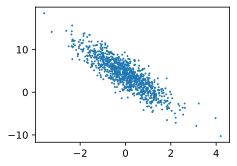

In [9]:
from IPython import display
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
# 加分号只显示图
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

将数据集分割为min_batch

In [10]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本的读取顺序是随机的
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 最后一次可能不足一个batch
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        # index_select函数根据索引返回对应元素
        yield features.index_select(0, j), labels.index_select(0, j)

In [11]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-1.6462,  0.1709],
        [ 0.4558,  0.6235],
        [ 0.3373,  0.3770],
        [ 0.0307,  0.2264],
        [ 2.5076, -0.0314],
        [ 0.0725,  0.5367],
        [-0.1730,  1.9244],
        [-0.4646, -0.8933],
        [-0.0945,  2.4027],
        [ 0.5763, -0.0477]]) tensor([ 0.3121,  2.9821,  3.5983,  3.4935,  9.3410,  2.5399, -2.6972,  6.3159,
        -4.1622,  5.5037])


初始化模型参数

In [12]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [13]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

线性回归模型

In [14]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

定义损失函数

In [15]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2 

定义优化算法

In [16]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

训练模型

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
# 训练模型一共需要num_epochs个迭代周期
for epoch in range(num_epochs):
    # 在每一个迭代周期中，会使用训练集中所有样本一次（假设样本数能够被批量大小整除）。
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        # l是有关小批量X和y的损失
        l = loss(net(X, w, b), y).sum()
        # 小批量损失对模型参数求梯度
        l.backward()
        # 使用小批量随机梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch+1, train_l.mean().item()))

epoch 1, loss 0.047065
epoch 2, loss 0.000212
epoch 3, loss 0.000052


模型参数

In [18]:
true_w, w

([2, -3.4],
 tensor([[ 1.9996],
         [-3.3996]], requires_grad=True))

In [19]:
true_b, b

(4.2, tensor([4.1998], requires_grad=True))

## 2.3 线性回归的简洁实现

生成数据集

In [20]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

读取数据集

In [21]:
import torch.utils.data as Data
batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [22]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[-1.3389, -0.5240],
        [ 0.7469,  1.8342],
        [ 0.1995,  1.0060],
        [ 0.7161, -0.0089],
        [-2.2405, -0.3061],
        [-0.5820, -0.0607],
        [ 0.1947,  0.4089],
        [-0.4646,  0.5088],
        [-0.2260, -0.6979],
        [ 0.3950, -1.4657]]) tensor([ 3.3100, -0.5506,  1.1639,  5.6708,  0.7600,  3.2509,  3.1950,  1.5539,
         6.1189,  9.9881])


定义模型

In [23]:
from torch import nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y
net = LinearNet(num_inputs)
# 打印网络结构
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [24]:
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
print(net)

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


查看模型的可学习参数

In [25]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.1997,  0.2664]], requires_grad=True)
Parameter containing:
tensor([0.4592], requires_grad=True)


初始化模型参数

In [26]:
from torch.nn import init
init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

损失函数

In [27]:
loss = nn.MSELoss()

优化器

In [28]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


模型训练

In [29]:
num_epochs = 3
for epoch in range(1, num_epochs+1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        # 梯度清零
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000228
epoch 2, loss: 0.000097
epoch 3, loss: 0.000180


In [30]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9998, -3.3992]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1989], requires_grad=True)


## 2.5 图像分类数据集

获取数据集

In [31]:
import torchvision
import torchvision.transforms as transforms

In [32]:
mnist_train = torchvision.datasets.FashionMNIST(root='data/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='data/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [33]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [34]:
feature, label = mnist_train[0]

In [35]:
feature.shape, feature.dtype

(torch.Size([1, 28, 28]), torch.float32)

In [36]:
label, type(label)

(9, int)

In [37]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [38]:
import d2lzh as d2l
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

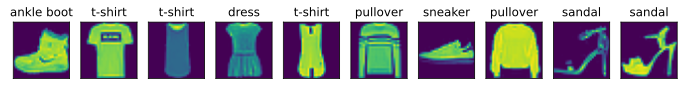

In [39]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

读取小批量

In [40]:
import sys
batch_size = 256
if sys.platform.startswith('win'):
    # 0表示不用额外的进程来加速读取数据
    num_workers = 0
else: 
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [41]:
start = time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time() - start))

3.22 sec


## 2.6 softmax回归的从零开始实现

In [42]:
import d2lzh as d2l

读取数据集

In [43]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

初始化模型参数

In [44]:
num_inputs = 784
num_outputs = 10
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float32)
b = torch.zeros(num_outputs, dtype=torch.float32)

In [45]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

张量按行、按列求和

In [46]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


softmax运算

In [47]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    # 这里应用了广播机制
    return X_exp / partition

In [48]:
X = torch.tensor(np.random.normal(0, 1, (2, 5)), dtype=torch.float32)
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1)

(tensor([[0.0983, 0.4965, 0.1170, 0.2383, 0.0498],
         [0.0446, 0.2138, 0.0424, 0.1218, 0.5774]]),
 tensor([1.0000, 1.0000]))

定义模型

In [49]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

定义损失函数

In [50]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
torch.gather(input=y_hat, dim=1, index=y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [51]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1, 1)))

计算分类准确率

In [52]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [53]:
accuracy(y_hat, y)

0.5

In [54]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [55]:
print(evaluate_accuracy(test_iter, net))

0.1267


训练模型

In [56]:
num_epochs, lr = 5, 0.1
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch+1, train_l_sum/n, train_acc_sum/n, test_acc))
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7847, train acc 0.749, test acc 0.791
epoch 2, loss 0.5703, train acc 0.814, test acc 0.814
epoch 3, loss 0.5254, train acc 0.825, test acc 0.819
epoch 4, loss 0.5018, train acc 0.832, test acc 0.824
epoch 5, loss 0.4851, train acc 0.837, test acc 0.829


预测

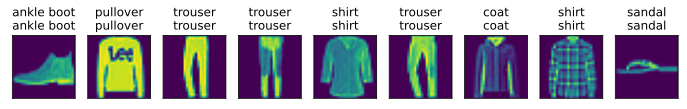

In [57]:
X, y = iter(test_iter).next()
true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
d2l.show_fashion_mnist(X[:9], titles[:9])

## 2.7 softmax回归的简洁实现

In [58]:
import torch
from torch import nn
from torch.nn import init
import d2lzh as d2l

读取数据集

In [59]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

定义和初始化模型

In [60]:
num_inputs = 784
num_outputs = 10
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    # x shape: (batch, 1, 28, 28)
    def forward(self, x):
        y = self.linear(x.view(x.shape[0], -1))
        return y
net = LinearNet(num_inputs, num_outputs)

In [61]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    # x shape: (batch, *, *, ...)
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [62]:
from collections import OrderedDict
net = nn.Sequential(
    OrderedDict([
        ('flatten', FlattenLayer()), 
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)

In [63]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

损失函数

In [64]:
loss = nn.CrossEntropyLoss()

优化算法

In [65]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

训练模型

In [66]:
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.751, test acc 0.786
epoch 2, loss 0.0022, train acc 0.814, test acc 0.780
epoch 3, loss 0.0021, train acc 0.826, test acc 0.813
epoch 4, loss 0.0020, train acc 0.833, test acc 0.812
epoch 5, loss 0.0019, train acc 0.836, test acc 0.821


## 2.8 多层感知机

In [67]:
def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name+'(x)')

ReLU

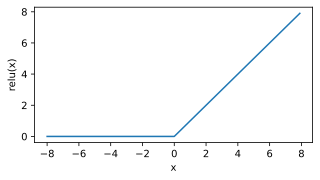

In [68]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

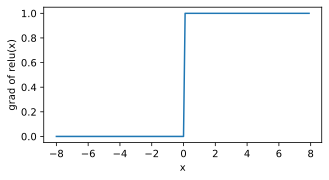

In [69]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

sigmoid

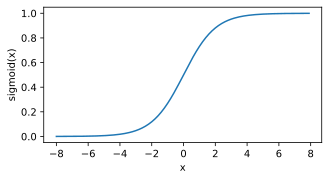

In [70]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

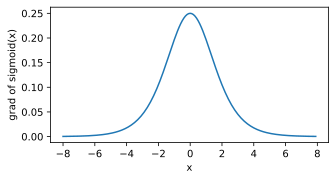

In [71]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

tanh

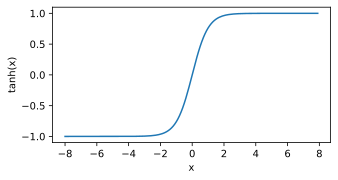

In [72]:
y = x.tanh()
xyplot(x, y, 'tanh')

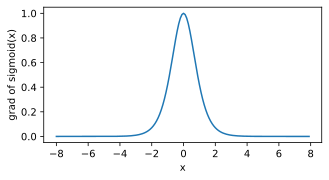

In [73]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

## 2.9 多层感知机的从零开始实现

读取数据

In [74]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

定义模型参数

In [75]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)
params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

定义激活函数

In [76]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

定义模型

In [77]:
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

定义损失函数

In [78]:
loss = torch.nn.CrossEntropyLoss()

训练模型

In [79]:
num_epochs, lr = 5, 100.0
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0030, train acc 0.712, test acc 0.791
epoch 2, loss 0.0019, train acc 0.825, test acc 0.825
epoch 3, loss 0.0017, train acc 0.845, test acc 0.823
epoch 4, loss 0.0015, train acc 0.856, test acc 0.805
epoch 5, loss 0.0015, train acc 0.862, test acc 0.855


## 2.10 多层感知机的简洁实现

定义模型

In [80]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
net = nn.Sequential(
    d2l.FlattenLayer(), 
    nn.Linear(num_inputs, num_hiddens), 
    nn.ReLU(), 
    nn.Linear(num_hiddens, num_outputs)
)
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

训练模型

In [81]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.701, test acc 0.754
epoch 2, loss 0.0019, train acc 0.815, test acc 0.820
epoch 3, loss 0.0017, train acc 0.842, test acc 0.781
epoch 4, loss 0.0015, train acc 0.856, test acc 0.829
epoch 5, loss 0.0014, train acc 0.864, test acc 0.834


## 2.11 模型选择、欠拟合和过拟合

生成数据集

In [82]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train+n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0]*poly_features[:, 0]+true_w[1]*poly_features[:, 1]+true_w[2]*poly_features[:, 2]+true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [83]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.7139],
         [-0.8752]]),
 tensor([[-0.7139,  0.5097, -0.3638],
         [-0.8752,  0.7660, -0.6704]]),
 tensor([ 0.3839, -2.4129]))

模型

In [84]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    # 对数坐标
    d2l.plt.semilogy(x_vals, y_vals)
    # 绘制测试集上的曲线
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [85]:
num_epochs, loss = 100, torch.nn.MSELoss()
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
            range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

final epoch: train loss 9.731649333843961e-05 test loss 9.888343629427254e-05
weight: tensor([[ 1.2049, -3.3998,  5.5985]]) 
bias: tensor([4.9985])


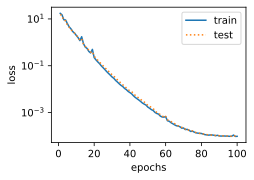

In [86]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 166.64437866210938 test loss 103.03386688232422
weight: tensor([[18.4239]]) 
bias: tensor([1.7832])


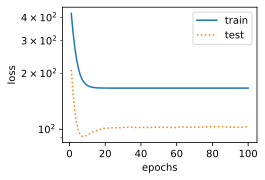

In [87]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 1.757625937461853 test loss 266.667236328125
weight: tensor([[-0.0885, -0.5889,  0.0629]]) 
bias: tensor([-0.7957])


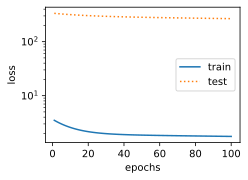

In [88]:
fit_and_plot(poly_features[:2, :], poly_features[n_train:, :], labels[:2], labels[n_train:])

## 2.12 权重衰减

数据准备

In [89]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
features = torch.randn((n_train+n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

初始化参数

In [90]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

L2惩罚项

In [91]:
def l2_penalty(w):
    return (w**2).sum() / 2

训练模型

In [92]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
                range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('L2 norm of w: ', w.norm().item())

L2 norm of w:  13.31631088256836


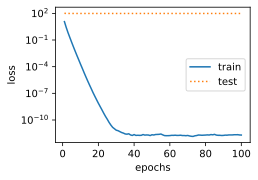

In [93]:
fit_and_plot(lambd=0)

L2 norm of w:  0.03995227813720703


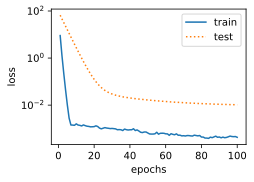

In [94]:
fit_and_plot(lambd=3)

简洁实现

In [95]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    # 对权重参数衰减
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
                range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('L2 norm of w: ', net.weight.data.norm().item())

L2 norm of w:  12.619309425354004


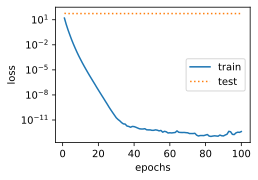

In [96]:
fit_and_plot_pytorch(0)

L2 norm of w:  0.03562627360224724


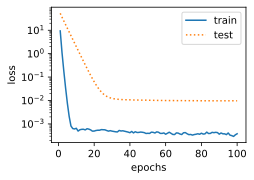

In [97]:
fit_and_plot_pytorch(3)

## 2.13 丢弃法

In [98]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    return mask * X / keep_prob

In [99]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [100]:
dropout(X, 0.5)

tensor([[ 0.,  2.,  4.,  0.,  8.,  0.,  0., 14.],
        [16., 18.,  0.,  0.,  0., 26.,  0., 30.]])

In [101]:
dropout(X, 1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

定义模型参数

In [102]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

定义模型

In [103]:
drop_prob1, drop_prob2 = 0.2, 0.5
def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    # 只在模型训练时使用丢弃法
    if is_training:
        # 在第一层全连接后添加丢弃层
        H1 = dropout(H1, drop_prob1)
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        # 在第二层全连接后添加丢弃层
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2, W3) + b3

训练和测试模型

In [104]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0045, train acc 0.546, test acc 0.768
epoch 2, loss 0.0023, train acc 0.786, test acc 0.813
epoch 3, loss 0.0019, train acc 0.821, test acc 0.818
epoch 4, loss 0.0017, train acc 0.839, test acc 0.824
epoch 5, loss 0.0016, train acc 0.850, test acc 0.804


简洁实现

In [105]:
net = nn.Sequential(
    d2l.FlattenLayer(), 
    nn.Linear(num_inputs, num_hiddens1), 
    nn.ReLU(), 
    nn.Dropout(drop_prob1), 
    nn.Linear(num_hiddens1, num_hiddens2), 
    nn.ReLU(), 
    nn.Dropout(drop_prob2), 
    nn.Linear(num_hiddens2, num_outputs)
)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [106]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0044, train acc 0.566, test acc 0.770
epoch 2, loss 0.0022, train acc 0.789, test acc 0.727
epoch 3, loss 0.0019, train acc 0.821, test acc 0.831
epoch 4, loss 0.0017, train acc 0.838, test acc 0.841
epoch 5, loss 0.0016, train acc 0.846, test acc 0.823


## 2.16 房价预测

In [107]:
# 如果没有安装pandas，则反注释下面一行
# ! pip install pandas
import pandas as pd

读取数据

In [108]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [109]:
train_data.shape

(1460, 81)

In [110]:
test_data.shape

(1459, 80)

In [111]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [112]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

预处理

In [114]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [115]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [116]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

训练模型

In [117]:
loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [118]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [128]:
def train(net, train_features, train_labels, test_features, test_labels, 
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化器
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

k折交叉验证

In [126]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j==i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [124]:
def k_fold(k, X_train, y_train, num_epochs, 
          learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse', 
                        range(1, num_epochs+1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

模型选择

fold 0, train rmse 0.170489, valid rmse 0.157037
fold 1, train rmse 0.162431, valid rmse 0.190838
fold 2, train rmse 0.164008, valid rmse 0.168377
fold 3, train rmse 0.168448, valid rmse 0.154738
fold 4, train rmse 0.163813, valid rmse 0.183044
5-fold validation: avg train rmse 0.165838, avg valid rmse 0.170807


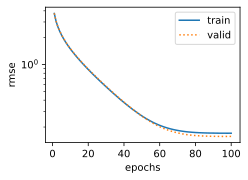

In [129]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

预测

In [130]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                  num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                       num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train rmse 0.162403


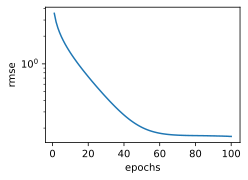

In [131]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)